In [2]:
] activate .

  Activating project at `~/Projects/HTM/Notebooks`


In [9]:
using BenchmarkTools
using CSV
using Distributions
using Markdown
using Plots
using Random
using SparseArrays
using StatsBase: Histogram
using Test
using Zygote

# Memory cost of storing all permanences is prohibitive

In [4]:
num_cols = 2048
col_size = 32
segment_per_cell = 128
synapses_per_segment = 50

num_cells = num_cols * col_size
segment_sparsity = synapses_per_segment / num_cells

# Each cell has x segments and each segment has one permanence (including zeros) per cell
total_floats = num_cells * segment_per_cell * num_cells
non_zero_floats = segment_sparsity * total_floats
bytes_to_gb = (1 / 1_000_000) * (1 / 1000)
GB_per_float64 = Base.summarysize(1.0) * bytes_to_gb
GB_per_float32 = Base.summarysize(1f0) * bytes_to_gb

println("Number of Cells: $(num_cells)")
println("\nNumber of permanence weights: $(total_floats)")
println("\t Size in memory (Float64): $(total_floats * GB_per_float64) GB")
println("\t Size in memory (Float32): $(total_floats * GB_per_float32) GB")
println("\nNumber of permanence weights (sparse): $(non_zero_floats)")
println("\t Size in memory (Float64): $(non_zero_floats * GB_per_float64) GB")
println("\t Size in memory (Float32): $(non_zero_floats * GB_per_float32) GB")

Number of Cells: 65536

Number of permanence weights: 549755813888
	 Size in memory (Float64): 4398.046511104 GB
	 Size in memory (Float32): 2199.023255552 GB

Number of permanence weights (sparse): 4.194304e8
	 Size in memory (Float64): 3.3554432000000003 GB
	 Size in memory (Float32): 1.6777216000000001 GB


# A look at the distribution of segment activation strengths

#### Parameters

In [ ]:
# Cells
n_cols = 2048
cells_per_col = 32
tot_cells = n_cols * cells_per_col

# Synapses
syn_per_seg = 50
sparsity = syn_per_seg / tot_cells

# Encoding number of active columns
encoding_active = 32

#### Make one segment per cell

In [133]:
# Build one segment per cell
segment_mat = sprand(tot_cells, tot_cells, sparsity)

65536×65536 SparseMatrixCSC{Float64, Int64} with 3279319 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

## Plot the distribution of segment activations for different numbers of columns active in encodings

In [213]:
h = histogram(sum(segment_mat, dims=2), 
    label="$n_cols cols", 
    xaxis=(:log10, [0.1, :auto]), 
    yaxis=(:log10, [0.1, :auto]),
    alpha=.8,
    size=(1000, 600),
    legendfontsize=10
)

num_encoding_cols = [16, 32, 64, 128]
for ne in reverse(num_encoding_cols)
    tot_enc_active = ne * cells_per_col
    ff = zeros(tot_cells)
    idxs = shuffle(1:tot_cells)[1:tot_enc_active]
    ff[idxs] .= 1.
    
    histogram!(h, segment_mat * ff, 
        label="$(ne) cols", 
        xaxis=(:log10, [0.1, :auto]),
        yaxis=(:log10, [0.1, :auto]),
        alpha=.8,
    )
end

plot(h)
title!(h, "Change in segment activation distibution \n with number of active input columns")
xlabel!("Segment activation level")
ylabel!("Frequency")

This plot shows the activation level of each segment for varying levels of feed-forward input activation levels. In blue is the distribution of segment activations for the case when all cells are active.

These activations are computed using the sum of permanence values and not the binary synapses. See below for binary synapses.

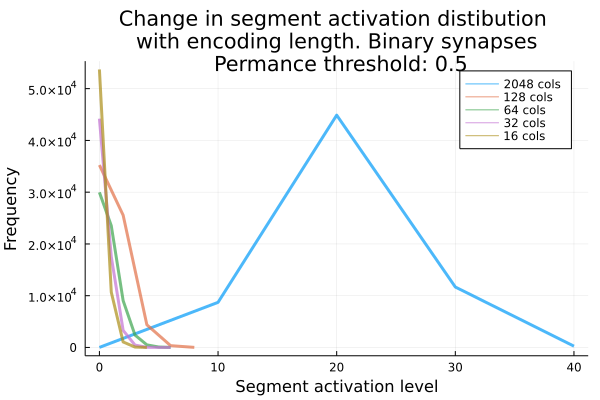

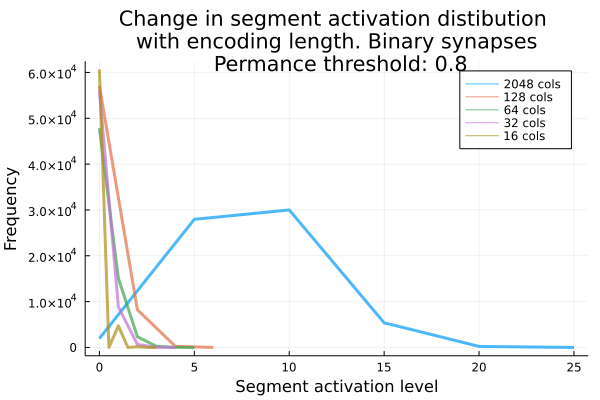

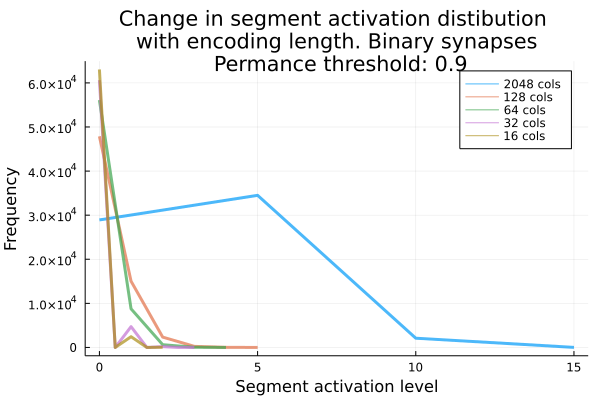

In [214]:
perm_threshes = [0.5, 0.8, 0.9]
nbins = 6

for pt in perm_threshes
    binary_seg_mat = segment_mat .> pt
    
    hfit = fit(Histogram, reshape(sum(binary_seg_mat, dims=2), :), nbins=nbins)
    h = plot(hfit.edges[1][1:end-1], hfit.weights, lw=3, alpha=.7, label="$n_cols cols")    
    

    num_encoding_cols = [16, 32, 64, 128]
    for ne in reverse(num_encoding_cols)
        tot_enc_active = ne * cells_per_col
        ff = zeros(tot_cells)
        idxs = shuffle(1:tot_cells)[1:tot_enc_active]
        ff[idxs] .= 1.

        hfit = fit(Histogram, reshape(binary_seg_mat * ff,:), nbins=nbins)
        plot!(h, hfit.edges[1][1:end-1], hfit.weights, lw=3, alpha=.7, label="$(ne) cols")
    end

    title!(h, string("Change in segment activation distibution \n with encoding ",
            "length. Binary synapses \n Permance threshold: $(pt)"))

    xlabel!(h, "Segment activation level")
    ylabel!(h, "Frequency")
    display(h)
end

# Learning the Taxicab data

### Can a frozen HTM architecture + linear classifier solve the problem?

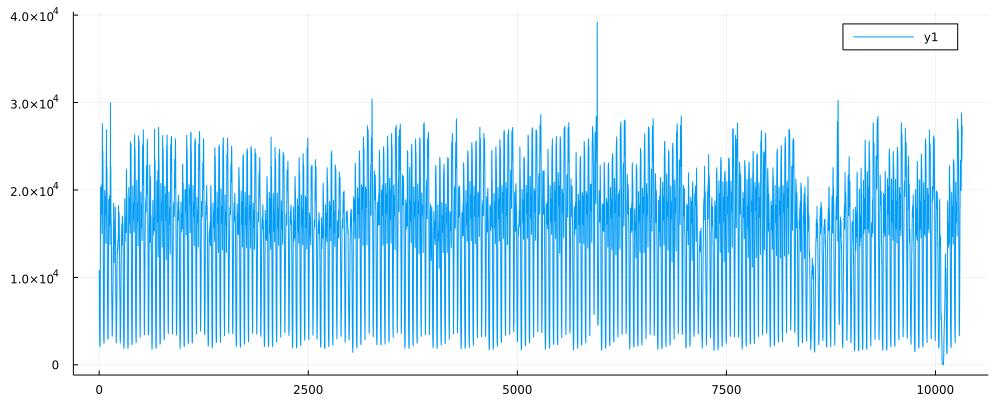

In [4]:
csv = CSV.File("../nyc_taxi.csv")
X = csv["value"]
plot(X, size=(1000, 400))

### Bin the taxicab data

In [5]:
"""
    which_bin(x, bin_width, start, stop)

Assumes a set of intervals with width `bin_width` between 
`start` and `stop`. Returns the index which interval
`x` belongs to.
"""
function which_bin(x, bin_width, start, stop)
    if x > stop 
        i = floor(Int, (stop - start) / bin_width)
    elseif x < start
        i = 0
    else
        i = floor(Int, (x - start) / bin_width)
    end
    return i + 1
end

# Make evenly spaced intervals for taxi data
num_bins = 101
bins = LinRange(minimum(X), maximum(X), num_bins)
bin_size = bins[2] - bins[1]

# Make a function that assigns data to the appropriate bin index
taxi_bin(x) = which_bin(x,  bin_size, bins.start, bins.stop)

taxi_bin (generic function with 1 method)

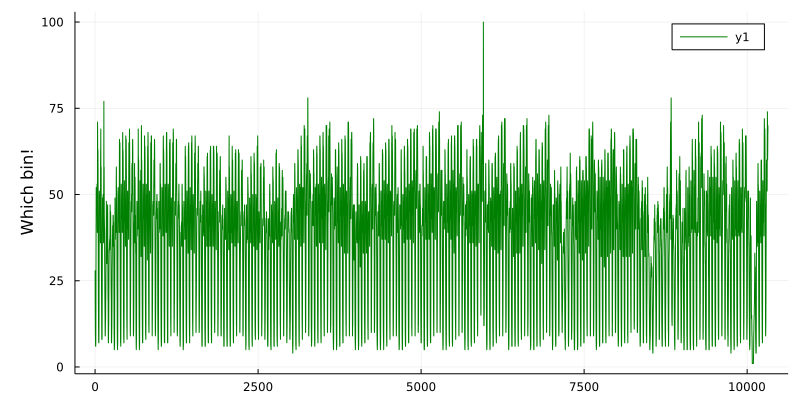

In [227]:
Z = map(taxi_bin, X)
plot(Z, c=:green, size=(800, 400))
ylabel!("\n\nWhich bin!") 

### Make an encoding for each bin

In [6]:
ENC_LEN = 1024
ENC_ACTIVE = 32
encodings = Dict(i => sample(1:ENC_LEN, ENC_ACTIVE; replace=false) for i in 1:(num_bins + 1));

### Encode the data

Pass on this to save memory

In [6]:
# num_points = length(X)

# encX = zeros(ENC_LEN, length(X))

# for i in 1:length(X)
#     active = encodings[taxi_bin(X[i])]
#     encX[active, i] .= 1.0
# end

### Make an HTM like architecture

In [25]:
# Parameters

# Cells and cols
num_cols = 1024
col_size = 32
num_cells = num_cols * col_size

# Segments and synapses
segments_per_cell = 64
synapses_per_segment = 50
segment_sparsity = synapses_per_segment / num_cells;

#### Put segments in sparse arrays

In [26]:
segments = [sprand(num_cells, num_cells, segment_sparsity) for i in 1:segments_per_cell];

In [22]:
# Finds the correct bin id
# Retrieves corresponding encoding (length equal to num_cols)
function small_input(x, num_cols) 
    idxs = encodings[taxi_bin(x)]
    enc = zeros(num_cols)
    enc[idxs] .= 1.
    return enc
end

# Repeats the encoding for each cell in the column
# Flattens the result
input_enc(x, num_cols, cells_per_col) = reshape(repeat(small_input(x, num_cols), 1, cells_per_col)', :)

input_enc (generic function with 2 methods)

In [43]:
ff = input_enc(800, num_cols, col_size)
sp_ff = SparseVector(ff)

println("Dense input vector mat mul")
@btime segments[1] * ff;

println("Sparse input vector mat mul")
@btime segments[1] * sp_ff;

Dense input vector mat mul
  13.474 s (3 allocations: 256.09 KiB)
Sparse input vector mat mul
  261.282 μs (8 allocations: 768.22 KiB)


In [41]:
@btime res = map(x -> x * sp_ff, segments);

  30.197 ms (517 allocations: 48.02 MiB)


In [46]:
println("Binary matrix due to permanence thresholding")
@btime res = map(x -> x * (sp_ff .> .5) , segments);

Binary matrix due to permanence thresholding
  30.418 ms (965 allocations: 48.60 MiB)


So. Fucking. Fast.

In [62]:
res = map(x -> x * sp_ff, segments);
idx, val = findnz(res[1])
print("New sparsity WITHOUT thresholding: $(length(idx) / length(res[1]))")

New sparsity WITHOUT thresholding: 0.788848876953125

In [49]:
res = map(x -> x * sp_ff .> .5, segments);
idx, val = findnz(res[1])
print("New sparsity WITH thresholding: $(length(idx) / length(res[1]))")

New sparsity WITH thresholding: 0.591796875

In [53]:
A = rand(2,2)
target = [1. 0 ; 0 1.]

relu(x) = Float64.(x > 0) * x
f(ps) = sum((relu.(A .- ps) - target) .^ 2)

f (generic function with 1 method)

In [54]:
gradient(f, rand(2,2))

([0.0 -0.4989008240442565; 0.0 0.0],)

In [ ]:
for x in X
    encode
    multiply
    threshold
    vote
    predict
end

In [ ]:
false_negative_loss(A, T, Y, α) = sum( (αY .- [(A .- T) .> 0]) .< 0 )

If a segment predicted correctly, lower it's threshold.

If a false negative occured, lower the threshold corresponding to the max activation.

If a false positive occurs increase threshold by a small amount.

Increase all thresholds by a small amount.

In [82]:
A = hcat(Array.(res)...)
T = 4 .* ones(size(A))
active = A .> T


target_enc = BitArray(input_enc(900, num_cols, col_size))

small_decr = 0.2
small_inc = 0.1
very_small_inc = 0.01

input_cols = Set(findall(!iszero, target_enc))
false_neg_count = Dict(i => 0 for i in input_cols)

@btime begin 
    for j in segments_per_cell

        a = active[:, j]

        # True positives
        true_pos = SparseVector(a .& target_enc)
        for i in first(findnz(true_pos))
            T[i, j] -= small_decr
        end

        # Misclassifications
        error = SparseVector(a - target_enc)
        idxs, vals = findnz(error)

        for (i, v) in zip(idx, vals)
            if v == -1 # False negative
                if i in input_cols
                    false_neg_count[i] += 1
                end
            elseif v == 1 # False positive
                T[i, j] += small_inc
            end
        end
    end


    T .+= very_small_inc;
end

  1.559 ms (6071 allocations: 574.70 KiB)


32768×64 Matrix{Float64}:
 58.74  58.74  58.74  58.74  58.74  …  58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74  …  58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74  …  58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
 58.74  58.74  58.74  58.74  58.74     58.74  58.74  58.74  58.74  58.74
  ⋮                      

In [98]:
println("Let's say it takes 40ms to matmul and update threshold. There are $(length(X)) 
ponts in taxicab. Then it would take $(0.04 * length(X) / 60) minutes to run through the
data once. We could do 10 batches in an hour, and the full 100 batches would take about 
12 hours. I could easilly add threads. I'm guessing that would be a 4X speedup at most. 
Putting us at 3 hours.
    
The sparse matmul is the bottleneck. I don't see any options for speeding that up. It is
too big to put on a GPU and too big to do anything dense with.
    
Then again, nobody seems to care how long it takes to train big deep neural nets so if we
improved the accuracy then it wouldn't matter. So we need to improve the accuracy a lot
to make a statement.

Given this, it seems like our best bet *would* be to use some ideas from DeepRL. Build in 
reward so that we grow connections for activating states that will lead us to good
states in the future.")

Let's say it takes 40ms to matmul and update threshold. There are 10320 
ponts in taxicab. Then it would take 6.88 minutes to run through the
data once. We could do 10 batches in an hour, and the full 100 batches would take about 
12 hours. I could easilly add threads. I'm guessing that would be a 4X speedup at most. 
Putting us at 3 hours.
    
The sparse matmul is the bottleneck. I don't see any options for speeding that up. It is
too big to put on a GPU and too big to do anything dense with.
    
Then again, nobody seems to care how long it takes to train big deep neural nets so if we
improved the accuracy then it wouldn't matter. So we need to improve the accuracy a lot
to make a statement.

Given this, it seems like our best bet *would* be to use some ideas from DeepRL. Build in 
reward so that we grow connections for activating states that will lead us to good
states in the future.


### We only have to do the giant matmul ONCE during training!! 

Amazing!! The data doesn't change, just the threshold.

In [18]:
struct TMThreshold{T}
    segments::Array{SparseMatrixCSC{Int, T}, 1}
    θ::Array{T, 2}
    cells_per_col::T
    small_decr::T
    small_incr::T
    very_small_incr::T
end

function TMThreshold(
        num_cells, 
        cells_per_col, 
        segments_per_cell, 
        synapses_per_segment; 
        initial_threshold=4., 
        smdcr=0.1, 
        smincr=0.1, 
        vsmdecr=0.01
)
    p = segments_per_cell / num_cells
    segments = [sprand(num_cells, num_cells, p) for i in 1:segments_per_cell]
    θ = initial_threshold .* ones(num_cells, segments_per_cell)
    return TMThreshold(segments, θ, cells_pre_col, smdcr, smincr, vsmdecr)
end

project(tmt::TMThreshold, x::SparseVector) = hcat(map(x -> Array(A * x), tmt.segments)...)

function update!(tmt::TMThreshold, segment_activation, target_enc_col_idxs)
    target = vectorize_encoding(target_enc_col_idxs)
    m, n = size(segment_activation)
    masked_activation = segment_activation .> tmt.threshold
    false_neg_counts = Dict{Int, Int}()
    
    # Iterate over columns of masked_activation
    for j in 1:n
        
        # True positives: Make more likely to activate
        act = masked_activation[:, j]
        for i in find(!iszero, act .& target)
            T[i, j] -= tmt.small_decr
        end
        
        # Misclassifications
        error = a - target_enc
        for i in 1:m
            # Find non-zero entries
            if error[i] != 0
                if error[i] == -1
                    # False negatives: count and apply update later
                    fn_count = get!(false_neg_count, i, 0)
                    false_neg_count[i] = fn_count + 1
                elseif v == 1
                    # False positive: Make less likely to activate
                    T[i, j] += tmt.small_incr
                end
            end
        end
    end
    
    # Check if no cells in a column entered a predictive state
    for i in target_enc_col_idxs
        expand_idxs = expand_enc_idx(i)
        tot_false_neg = mapreduce(idx -> false_neg_counts[idx], sum, expand_idx)
        # Check if all segments on cells corresponding to an active input 
        # were a false negative.
        if tot_false_neg == (tmt.cells_per_col * segments_per_cell)
            # Find the segment corresponding to the unpredicted column
            # That was the closest to activating 
            cidx = argmax(segment_activation[expand_idxs, :])
            # Compute index relative to entire array
            ci, j = Tuple(cidx)
            i = expand_idx[ci]
            # Decrease threshold for the segment that was the closest to firing.
            T[i, j] -= tmt.small_decr
        end
    end
        
    # Increase all thresholds by a very small amount
    T .+= tmt.very_small_incr
end
    


update! (generic function with 1 method)

In [ ]:

tmt = TMThreshold(

In [12]:
function expand_enc_idx(enc_idx::Int, cells_per_col)
    idxs = (1 + (enc_idx - 1) * cells_per_col):(enc_idx * cells_per_col)
    return idxs
end

@test expand_enc_idx(1, 2) == 1:2
@test expand_enc_idx(3, 7) == 15:21

Test Passed
  Expression: expand_enc_idx(3, 7) == 15:21
   Evaluated: 15:21 == 15:21

In [15]:
ci = first(Tuple(argmax(rand(2,2))))
expand_enc_idx(2, 10)[ci]

11